## Participation score and Activity Diagram


This notebook calculates the participation score for each user.

Outpute is saved as ```outputs/participation.csv```

Participation $p_i$ for a user is defined as:

$$p_i = log(1+ obs_i + ident_i)$$

where $obs_i$ and $ident_i$ are the observations and identifications per user, respectively.


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime
import seaborn as sns

In [251]:
from matplotlib.colors import LogNorm, Normalize


### Load Data

In [2]:
cities_years = {
    'London': [2018, 2019, 2020],
    'Los_Angeles': [2018, 2019, 2020],
    'San_Francisco': [2018, 2019, 2020],
}

import seaborn as sns
cities_colors = {
    'London': sns.color_palette("Blues", n_colors = 3),
    'Los_Angeles': sns.color_palette("Reds", n_colors = 3),
    'San_Francisco': sns.color_palette("Greens", n_colors = 3),
}

In [3]:
from collections import defaultdict
dfs = defaultdict(dict)
dfall = []

for city, years in cities_years.items():
    for year in years:
        print("Loading: ", city, year)
        df = pd.read_csv("../data/raw/observations_v2/CNC_{}_{}.csv".format(city, year))
        dfs[city][year] = df
        dfall.append(df)

dfall = pd.concat(dfall)
dfs['London'][2018].head()

Loading:  London 2018
Loading:  London 2019
Loading:  London 2020
Loading:  Los_Angeles 2018
Loading:  Los_Angeles 2019
Loading:  Los_Angeles 2020
Loading:  San_Francisco 2018
Loading:  San_Francisco 2019
Loading:  San_Francisco 2020


,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11479007,2018-04-27 7:52:34 am BST,2018-04-27T07:52:34+00:00,Etc/UTC,2018-04-27T07:06:17+00:00,2018-04-27T09:26:56+00:00,NaN,159021,muki,research,...,lesser celandine,Plantae,species,204212,True,False,False,26862,26862,"[{'user_id': 353381, 'category': 'improving', ..."
1,11480212,2018-04-27 8:39:41 am BST,2018-04-27T08:39:41+01:00,Europe/London,2018-04-27T09:02:52+01:00,2019-01-29T21:16:34+00:00,NaN,664459,lucyrobinsonnhm,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,38831,38831,"[{'user_id': 29729, 'category': 'supporting', ..."
2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27T08:34:31+02:00,Europe/Amsterdam,2018-04-27T10:42:01+02:00,2018-04-27T13:01:49+02:00,NaN,908315,tess26,casual,...,Spanish Bluebell,Plantae,species,56095,False,False,False,2801,2801,"[{'user_id': 908315, 'category': 'leading', 'd..."
3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27T09:54:35+02:00,Europe/Amsterdam,2018-04-27T10:54:45+02:00,2018-04-27T22:23:41+02:00,NaN,796473,bryonycross,research,...,Green Alkanet,Plantae,species,156638,False,False,False,4509,4509,"[{'user_id': 160, 'category': 'improving', 'di..."
4,11482247,2018-04-27 8:42:21 am BST,2018-04-27T08:42:21+01:00,Europe/London,2018-04-27T11:09:55+01:00,2018-04-27T16:37:31+01:00,NaN,664459,lucyrobinsonnhm,research,...,London Plane,Plantae,hybrid,49664,False,False,False,5475,5475,"[{'user_id': 160, 'category': 'supporting', 'd..."


# Calculate participation

## Get number of observations and identifications

In [4]:
def get_obs_idents_per_user(dfcity):
    """ Calculate the number of observations and identifications per user 
    
    Input:
    ------
     - dfcity: pd.DataFrame
         The observations data for one city.
    
    Returns:
    -------
     - dfobsident: pd.DataFrame
         Has the columns: user_id | n_obs | n_idents
    
    """
    from collections import defaultdict
    n_obs = defaultdict(int)
    n_idents = defaultdict(int)


    for _, row in dfcity.iterrows():
        # Count observation to user that observed
        user_obs = row['user_id']
        n_obs[user_obs] += 1

        # Count identications the user did
        identifications = eval(row['identifications'])
        for ident in identifications:
            user_ident = ident['user_id']
            if user_ident != user_obs:
                n_idents[user_ident] += 1
    # Create dataframe with observations, identifications
    dfobsident = pd.DataFrame([n_obs, n_idents]).T.reset_index().convert_dtypes().fillna(0)
    dfobsident.columns = ['user_id', 'n_obs', 'n_idents']
    dfobsident
    return dfobsident

In [5]:
dfcity = dfs['San_Francisco'][2020]
dfobsident = get_obs_idents_per_user(dfcity)
dfobsident

,user_id,n_obs,n_idents
0,2692,278,204
1,179103,369,3494
2,819,319,57
3,2825732,34,3
4,2556410,4,0
...,...,...,...
3798,2563903,0,1
3799,1131523,0,1
3800,523509,0,1
3801,3098822,0,1


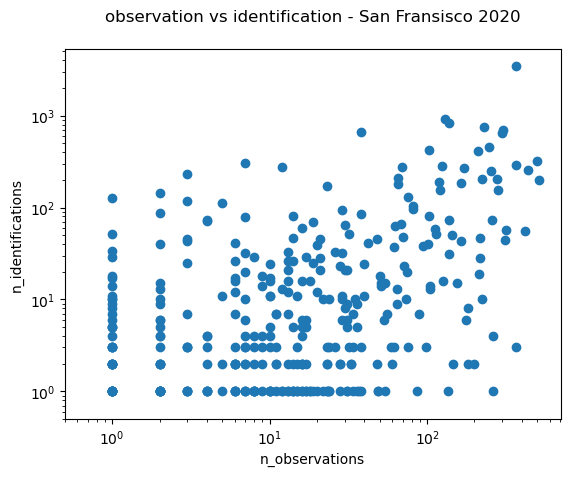

In [6]:
plt.scatter(dfobsident['n_obs'], dfobsident['n_idents'])
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xlim(xmin=0.5)
plt.gca().set_ylim(ymin=0.5)
plt.title("observation vs identification - San Fransisco 2020", pad=20)
plt.xlabel("n_observations")
plt.ylabel("n_identifications")
plt.show()

### Calculate partipication score
##### Score of cumulative participations distribution for each user is estimated as S_a = log(1+N_obs+N_id) for different CNC events

In [7]:
def cumulative_participation(df):
    """ Calculate the participation score from
    observations and identifications.
    """
    df['participation cumulative'] = np.log10(1 + df['n_obs'] + df['n_idents'])
    return df

dfobsident_c = cumulative_participation(dfobsident)

### Score of participation differences
##### Average online vs.onsite participation score
##### 2 S_oo = log (1+ abs(N_id - N_obs)).

In [8]:
def calc_participation_dif(df):
    """ Calculate the participation index from
    observations and identifications.
    """
    
    df['participation difference'] = np.log10((1 + np.abs(df['n_idents'] - df['n_obs'])))

    return df

dfobsident_d = calc_participation_dif(dfobsident)


### Score of Participation Index
##### 1 S_oo = abs(N_id -N_obs)/abs(N_id +N_obs)

In [9]:
def calc_participation_index(df):
    """ Calculate the participation index from
    observations and identifications.
    """
    df['participation index'] = np.abs((df['n_idents'] - df['n_obs']) / (df['n_idents'] + df['n_obs']))
    return df 

dfobsident_i = calc_participation_index(dfobsident)

### Save participants for all cities with scores

In [10]:
def get_participation_all_cities(dfs, cities_years):
    dfobs = []
    for city, years in cities_years.items():
        for year in years:
            print(city, year)
            dfcity = dfs[city][year]
            dfobsident = get_obs_idents_per_user(dfcity)
            dfobsident_c = cumulative_participation(dfobsident)
            dfobsident_d = calc_participation_dif(dfobsident)
            dfobsident_i = calc_participation_index(dfobsident)
            dfobsident['city'] = city
            dfobsident['year'] = year
            dfobs.append(dfobsident)
    dfobs = pd.concat(dfobs)
    dfobs = dfobs.sort_values(by=['year', 'city', 'user_id'])
    return dfobs

dfobs = get_participation_all_cities(dfs, cities_years)
dfobs.to_csv("C://Users//User//Downloads//citizen_science_inaturalist-main//data//outputs//participation.csv", index=False)
dfobs

London 2018
London 2019
London 2020
Los_Angeles 2018
Los_Angeles 2019
Los_Angeles 2020
San_Francisco 2018
San_Francisco 2019
San_Francisco 2020


,user_id,n_obs,n_idents,participation cumulative,participation difference,participation index,city,year
291,1,0,1,0.30103,0.30103,1.0,London,2018
110,160,0,524,2.720159,2.720159,1.0,London,2018
176,351,0,9,1.0,1.0,1.0,London,2018
356,462,0,1,0.30103,0.30103,1.0,London,2018
188,477,0,6,0.845098,0.845098,1.0,London,2018
...,...,...,...,...,...,...,...,...
3572,3638742,0,1,0.30103,0.30103,1.0,San_Francisco,2020
3237,3657355,0,3,0.60206,0.60206,1.0,San_Francisco,2020
2700,3728745,1,0,0.30103,0.30103,1.0,San_Francisco,2020
2705,3780892,0,1,0.30103,0.30103,1.0,San_Francisco,2020


### London Observation vs Identification¶

In [11]:
lon_dbo = dfobs[dfobs.city == 'London'].sort_values(['n_obs'], ascending = False).fillna(0)
lon_dbo = lon_dbo[lon_dbo['n_obs'] >= 10]
lon_dbo

,user_id,n_obs,n_idents,participation cumulative,participation difference,participation index,city,year
10,353381,1085,6,3.038223,3.033424,0.989001,London,2019
8,353381,567,10,2.761928,2.746634,0.965338,London,2018
3,1488476,355,1218,3.197005,2.936514,0.548633,London,2020
92,2782355,299,20,2.50515,2.447158,0.874608,London,2020
149,353381,274,2,2.44248,2.436163,0.985507,London,2020
...,...,...,...,...,...,...,...,...
55,921493,10,2,1.113943,0.954243,0.666667,London,2018
18,2826632,10,0,1.041393,1.041393,1.0,London,2020
318,908366,10,0,1.041393,1.041393,1.0,London,2020
80,2785054,10,0,1.041393,1.041393,1.0,London,2020


In [73]:
df_obs_c  = pd.pivot_table(lon_dbo,index="user_id", columns="year",aggfunc=np.sum)[['n_obs']].astype(float).fillna(0)
df_obs_c = df_obs_c.sort_values(by=[('n_obs', 2018)],ascending=False)
df_obs_c


n_obs               
year      2018    2019   2020
user_id                      
353381   567.0  1085.0  274.0
664459   150.0    13.0    0.0
911337   125.0     0.0    0.0
883351    97.0    33.0   61.0
781146    95.0   145.0    0.0
...        ...     ...    ...
1663808    0.0    46.0    0.0
1666955    0.0    18.0    0.0
1666984    0.0    19.0    0.0
1669656    0.0    31.0    0.0
2863283    0.0     0.0   17.0

[221 rows x 3 columns]

In [74]:
df_obs_c.columns

MultiIndex([('n_obs', 2018),
            ('n_obs', 2019),
            ('n_obs', 2020)],
           names=[None, 'year'])

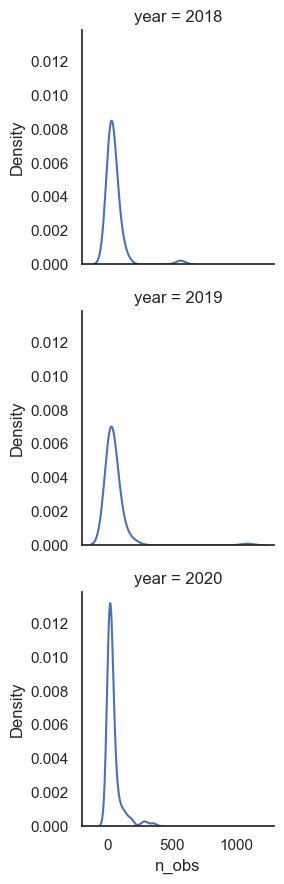

In [13]:
sns.set_theme(style="white")
g = sns.FacetGrid(lon_dbo, row="year")
g.map_dataframe(sns.kdeplot, x="n_obs")

Text(0.5, 0.98, 'Cumulative User Identification by year - London')

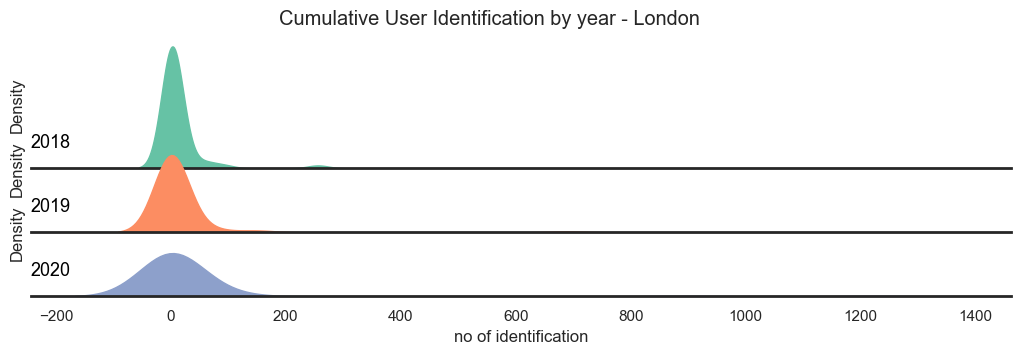

In [74]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(lon_dbo, palette=palette, row="year", hue="year", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="n_idents", fill=True, alpha=1)
#g.map_dataframe(sns.kdeplot, x="n_obs", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "year")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="no of identification")
g.despine( left=True)

plt.suptitle('Cumulative User Identification by year - London', y=0.98)

In [89]:
print(lon_dbo[:10])

     user_id  n_obs  n_idents  participation cumulative  \
10    353381   1085         6                  3.038223   
8     353381    567        10                  2.761928   
3    1488476    355      1218                  3.197005   
92   2782355    299        20                   2.50515   
149   353381    274         2                   2.44248   
98   1358449    219         1                  2.344392   
257   923147    202         4                   2.31597   
10   1624432    185         1                  2.271842   
208   908569    183         0                  2.264818   
32    894051    163       689                  2.930949   

     participation difference  participation index    city  year  
10                   3.033424             0.989001  London  2019  
8                    2.746634             0.965338  London  2018  
3                    2.936514             0.548633  London  2020  
92                   2.447158             0.874608  London  2020  
149            

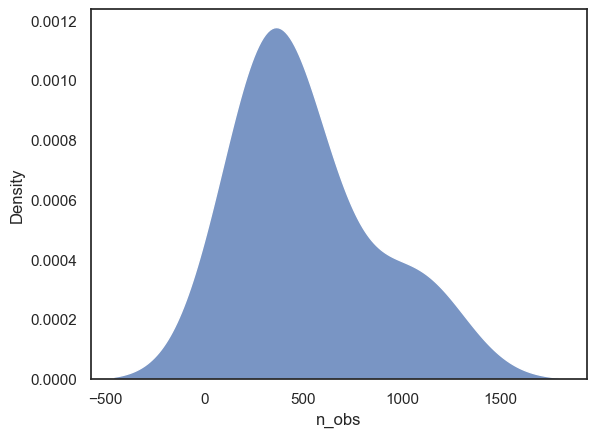

In [53]:
sns.kdeplot(data=lon_dbo[:5],x='n_obs',multiple='stack')
plt.show()

In [75]:
import warnings
warnings.filterwarnings("ignore")

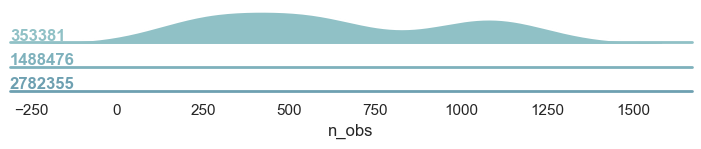

In [76]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(lon_dbo[:5], row="user_id", hue="user_id", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "n_obs",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "n_obs", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "n_obs")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

### Progress for three years - London observation

In [130]:
lon_ob = lon_dbo.groupby(['user_id','year'])['n_obs'].agg("sum").unstack().fillna(0).astype(float)
lon_ob = lon_ob.sort_values([2018],ascending=False)
lon_ob

year,2018,2019,2020
user_id,,,
353381,567.0,1085.0,274.0
664459,150.0,13.0,0.0
911337,125.0,0.0,0.0
883351,97.0,33.0,61.0
781146,95.0,145.0,0.0
...,...,...,...
1663808,0.0,46.0,0.0
1666955,0.0,18.0,0.0
1666984,0.0,19.0,0.0


In [245]:
lon_ob.columns=lon_ob.columns
lon_ob.reset_index(inplace=True)

In [246]:
lon_ob

year,user_id,2018,2019,2020
0,353381,567.0,1085.0,274.0
1,664459,150.0,13.0,0.0
2,911337,125.0,0.0,0.0
3,883351,97.0,33.0,61.0
4,781146,95.0,145.0,0.0
5,923147,88.0,202.0,0.0
6,908569,85.0,0.0,183.0
7,898798,75.0,0.0,22.0
8,910492,67.0,0.0,0.0
9,921393,66.0,0.0,0.0


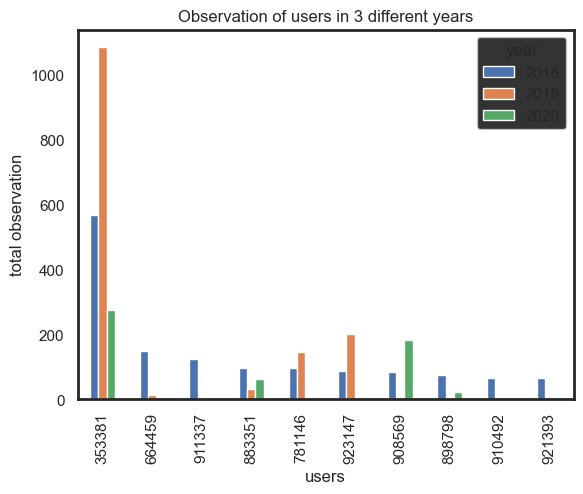

In [249]:
ax = lon_ob[:10].plot.bar()
plt.title('Observation of users in 3 different years')
plt.xlabel('users')
plt.ylabel('total observation')
plt.xticks(rotation='vertical');

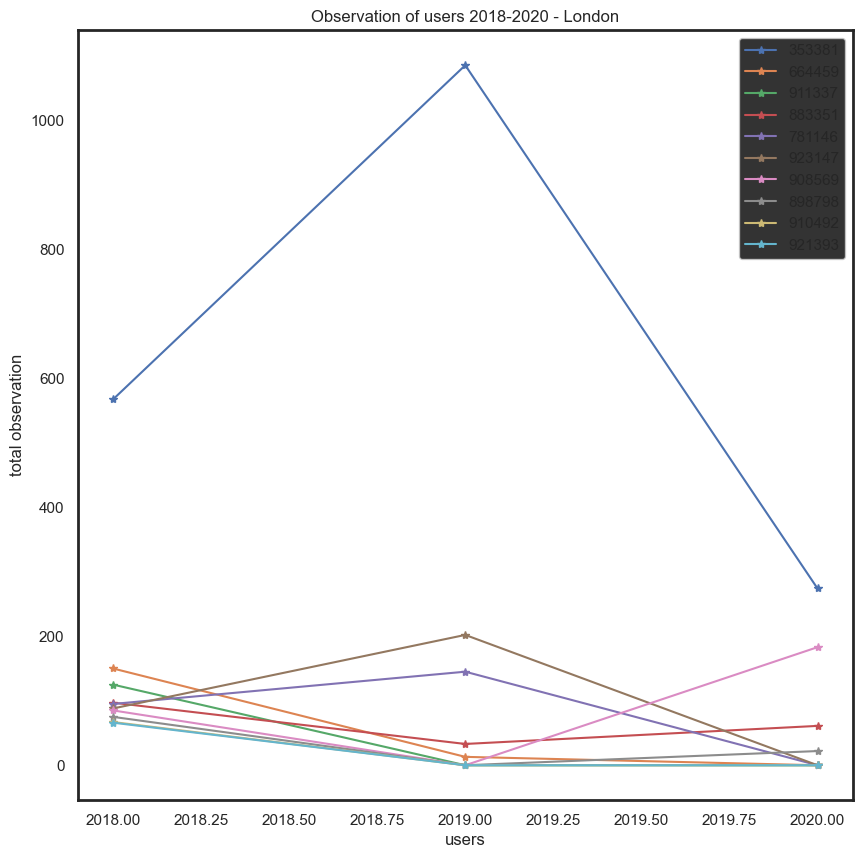

In [248]:
# Create an empty list to store the lines

lon_ob = lon_ob.set_index('user_id')[:10]
fig, ax = plt.subplots(figsize=(10,10))
for index, row in lon_ob.iterrows():
    plt.plot(row, label=index,marker="*")
#plt.xscale('log')
#plt.yscale('log')

# Add a legend to the plot
plt.title('Observation of users 2018-2020 - London')
plt.xlabel('users')
plt.ylabel('total observation')
plt.legend()
plt.show()

In [15]:
lon_ob.columns

Index(['user_id', 2018, 2019, 2020], dtype='object', name='year')

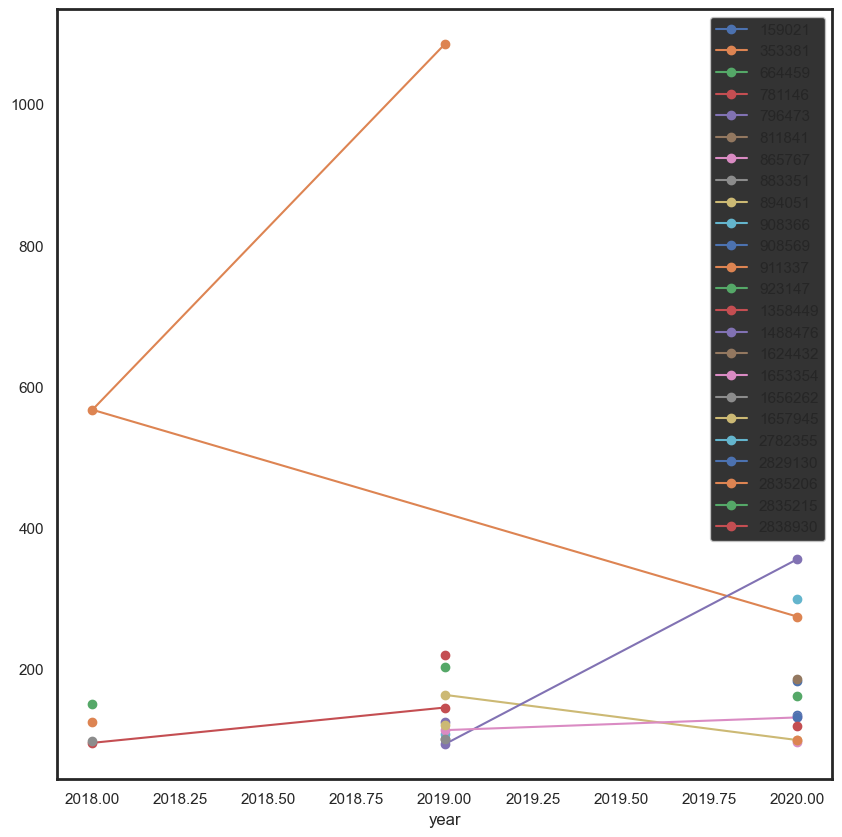

In [250]:
fig, ax = plt.subplots(figsize=(10,10))
for i, user in lon_dbo[:30].groupby(['user_id']):
    user.plot(x='year', y='n_obs', label=i, marker="o",ax=ax)
# Add a legend to the plot
plt.legend()

In [28]:

from matplotlib.colors import LogNorm, Normalize

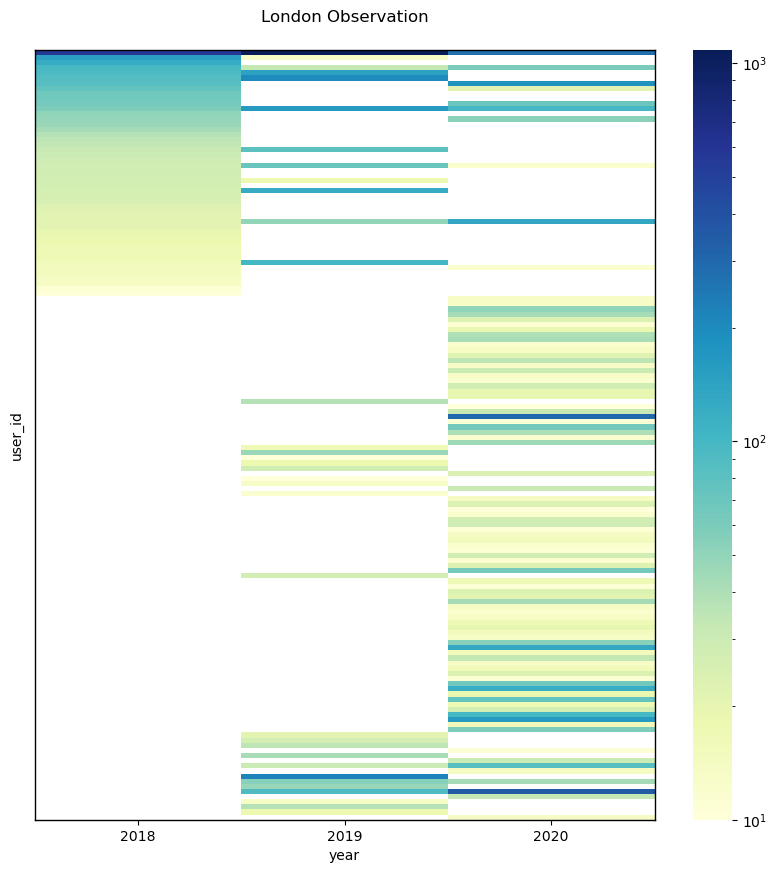

In [33]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

lon = sns.heatmap(lon_ob[:150], fmt='g',ax=ax,cmap="YlGnBu",yticklabels=False,norm=LogNorm());
ax.set_title('London Observation',fontsize = 12, pad=20)
for _, spine in lon.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

### Progress for three years - London identification

In [38]:
lon_iden = lon_dbo.groupby(['user_id','year'])['n_idents'].agg("sum").unstack().fillna(0).astype(float)
lon_iden = lon_iden.sort_values([2018],ascending=False)
lon_iden

year,2018,2019,2020
user_id,,,
147030,256.0,0.0,0.0
894051,92.0,689.0,887.0
910492,62.0,0.0,0.0
664459,55.0,152.0,0.0
921545,20.0,0.0,0.0
...,...,...,...
1636662,0.0,0.0,0.0
1646196,0.0,0.0,0.0
1653354,0.0,65.0,116.0


Text(0.5, 1.0, 'London Identification')

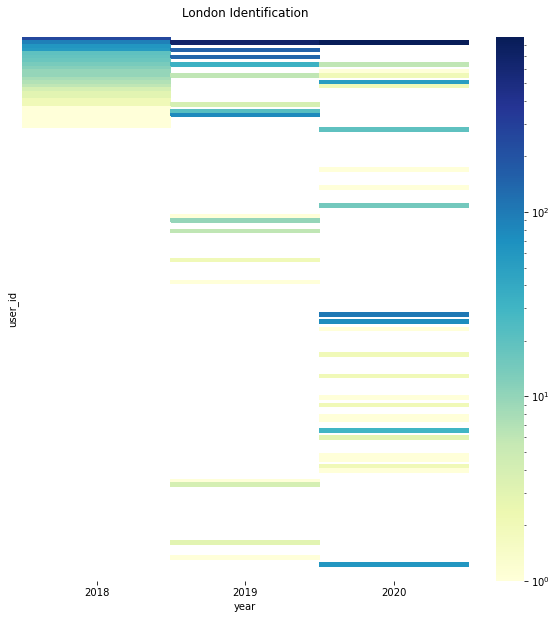

In [41]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(lon_iden[:150], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('London Identification',fontsize = 12, pad=20)

### Cumulative - London Observation and Identification for all three years 

In [18]:
#lon_cum = lon_dbo.groupby('user_id')['n_obs'].sum()

In [164]:
lon_cum = lon_dbo.groupby('user_id')[['n_obs', 'n_idents']].sum().sort_values([('n_obs')], ascending=False).astype(float)
lon_cum

,n_obs,n_idents
user_id,,
353381,1926.0,18.0
1488476,448.0,1219.0
894051,320.0,1668.0
2782355,299.0,20.0
923147,290.0,6.0
...,...,...
1680805,10.0,0.0
1688726,10.0,0.0
921493,10.0,2.0


In [265]:
lon_cum.columns=lon_cum.columns
lon_cum.reset_index(inplace=True)
lon_cum

,user_id,n_obs,n_idents
0,353381,1926.0,18.0
1,1488476,448.0,1219.0
2,894051,320.0,1668.0
3,2782355,299.0,20.0
4,923147,290.0,6.0
5,908569,268.0,0.0
6,1653354,244.0,181.0
7,781146,240.0,0.0
8,1358449,219.0,1.0
9,1624432,214.0,1.0


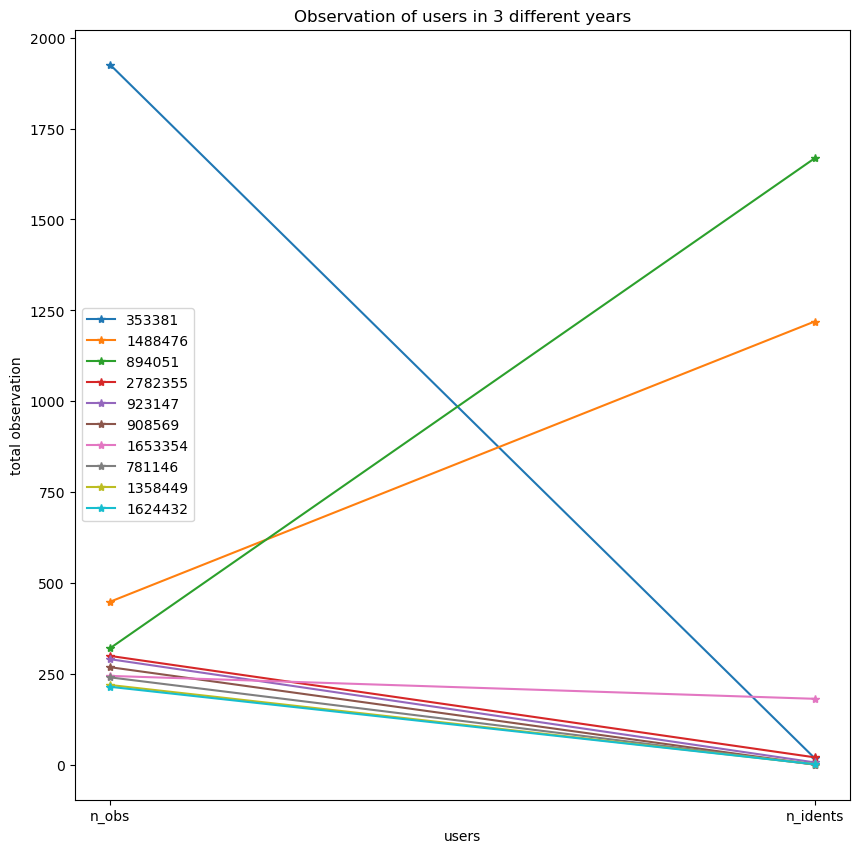

In [198]:

lon_cum = lon_cum.set_index('user_id')[:10]
fig, ax = plt.subplots(figsize=(10,10))
for index, row in lon_cum.iterrows():
    plt.plot(row, label=index,marker="*")
#plt.xscale('log')
#plt.yscale('log')

# Add a legend to the plot
plt.title('Observation of users in 3 different years')
plt.xlabel('users')
plt.ylabel('total observation')
plt.legend()
plt.show()

In [262]:
# Plot lines
###x = lon_cum['n_idents']
#y = lon_cum['n_obs']
#ax.plot(lon_cum, x, color="green")
#x.plot(lon_cum, y, color="red")

# plot lines
##plt.plot(x, color="green",label = "identification")
#plt.plot(y, color="red", label = "observation")
#plt.legend()
#plt.show()


In [165]:
lon_cum.columns

Index(['n_obs', 'n_idents'], dtype='object')

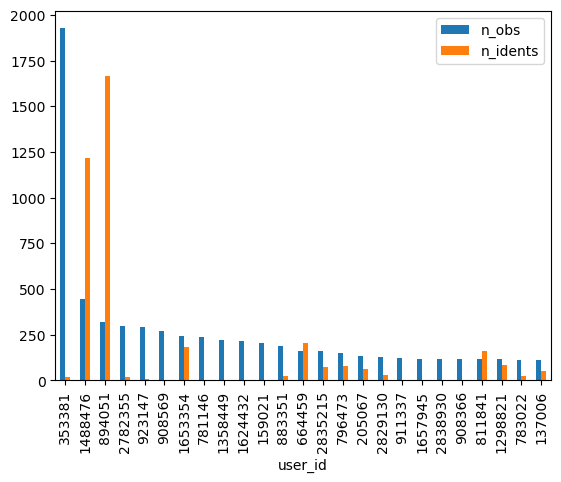

In [192]:
ax = lon_cum[:25].plot.bar(rot=0)
plt.xticks(rotation='vertical');


Text(0.5, 1.0, 'Cumulative Observation and Identification - London (2018-2020)')

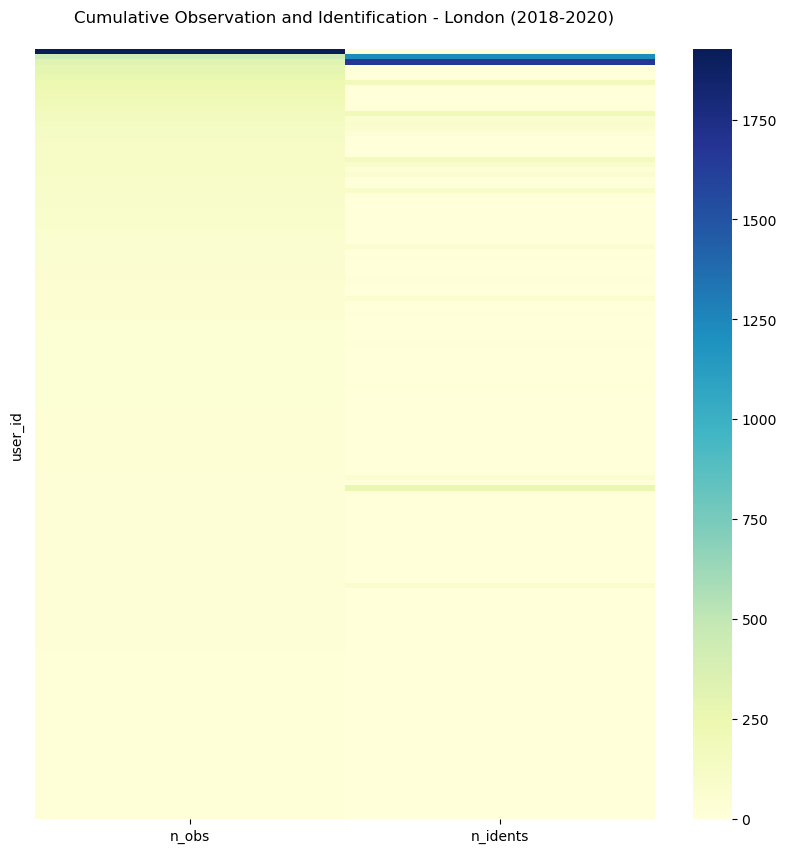

In [114]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(lon_cum[:150], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False);
ax.set_title('Cumulative Observation and Identification - London (2018-2020)',fontsize = 12, pad=20)

In [21]:
#df_obs_c  = pd.pivot_table(lon_dbo,index="user_id", columns="city",aggfunc=np.sum)[['n_obs','n_idents']].sort_values([('n_obs', 'London')], ascending=False).astype(float)
#df_obs_c


,n_obs,n_idents
city,London,London
user_id,,
353381,1926.0,18.0
1488476,448.0,1219.0
894051,320.0,1668.0
2782355,299.0,20.0
923147,290.0,6.0
...,...,...
1680805,10.0,0.0
1688726,10.0,0.0


In [39]:
#fig, ax = plt.subplots(figsize=(5,18))         # Sample figsize in inches
#sns.heatmap(df_obs_c, fmt='g', linewidth=1,ax=ax);

## San Fransisco - observation vs Identification

In [206]:
sf_dbo = dfobs[dfobs.city == 'San_Francisco'].sort_values(['n_obs'], ascending = False)
sf_dbo = sf_dbo[sf_dbo['n_obs'] >= 10]
sf_dbo

,user_id,n_obs,n_idents,participation cumulative,participation difference,participation index,city,year
7,2991,889,838,3.237544,1.716003,0.029531,San_Francisco,2018
1891,2991,735,27,2.882525,2.850646,0.929134,San_Francisco,2019
3,34038,699,501,3.079543,2.298853,0.165,San_Francisco,2019
13,8778,612,544,3.063333,1.838849,0.058824,San_Francisco,2019
281,16101,600,986,3.200577,2.587711,0.24338,San_Francisco,2018
...,...,...,...,...,...,...,...,...
180,771714,10,0,1.041393,1.041393,1.0,San_Francisco,2018
178,23018,10,0,1.041393,1.041393,1.0,San_Francisco,2020
1525,115786,10,0,1.041393,1.041393,1.0,San_Francisco,2018
1512,21209,10,0,1.041393,1.041393,1.0,San_Francisco,2019


Text(0.5, 0.98, 'Cumulative User Observation by year - San Fransisco')

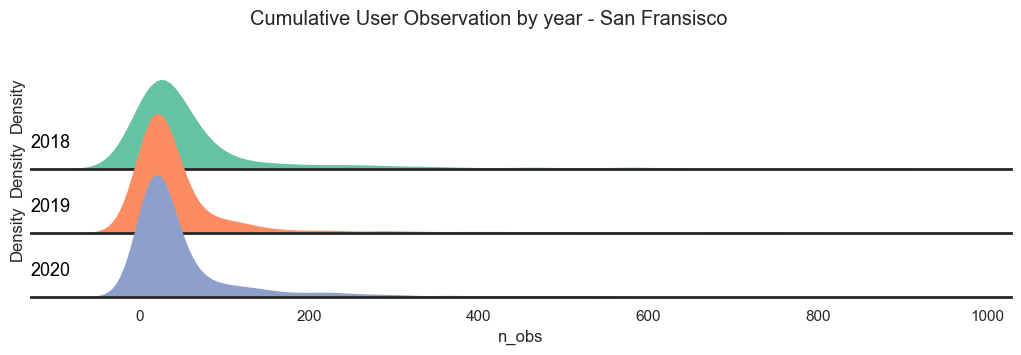

In [207]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(sf_dbo, palette=palette, row="year", hue="year", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="n_obs", fill=True, alpha=1)
#g.map_dataframe(sns.kdeplot, x="n_obs", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "year")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="n_obs")
g.despine( left=True)

plt.suptitle('Cumulative User Observation by year - San Fransisco', y=0.98)

In [208]:
participation = sf_dbo.groupby(['user_id','year'])['participation difference'].agg("sum").unstack().fillna(0).astype(float)
participation[:10]

year,2018,2019,2020
user_id,,,
1,3.142076,2.453318,2.841359
17,1.477121,0.000000,0.000000
28,2.602060,0.000000,2.589950
181,1.851258,1.361728,0.000000
425,0.000000,1.079181,0.000000
462,0.000000,1.414973,0.000000
477,2.487138,0.845098,0.000000
498,1.623249,1.707570,0.000000
505,0.000000,1.230449,1.591065


### Progress for three years - SF observation

In [232]:
sf_ob = sf_dbo.groupby(['user_id','year'])['n_obs'].agg("sum").unstack().fillna(0).astype(float)
sf_ob = sf_ob.sort_values([2018],ascending=False)
sf_ob

year,2018,2019,2020
user_id,,,
2991,889.0,735.0,370.0
16101,600.0,0.0,181.0
4862,598.0,0.0,0.0
34038,588.0,699.0,441.0
17796,588.0,0.0,458.0
...,...,...,...
1044972,0.0,0.0,27.0
1046289,0.0,83.0,0.0
1050380,0.0,22.0,0.0


In [241]:
sf_ob.columns=sf_ob.columns
sf_ob.reset_index(inplace=True)
sf_ob

year,user_id,2018,2019,2020
0,2991,889.0,735.0,370.0
1,16101,600.0,0.0,181.0
2,4862,598.0,0.0,0.0
3,34038,588.0,699.0,441.0
4,17796,588.0,0.0,458.0
5,3494,575.0,558.0,114.0
6,23297,554.0,381.0,69.0
7,179103,544.0,492.0,369.0
8,7302,504.0,483.0,517.0
9,8778,483.0,612.0,300.0


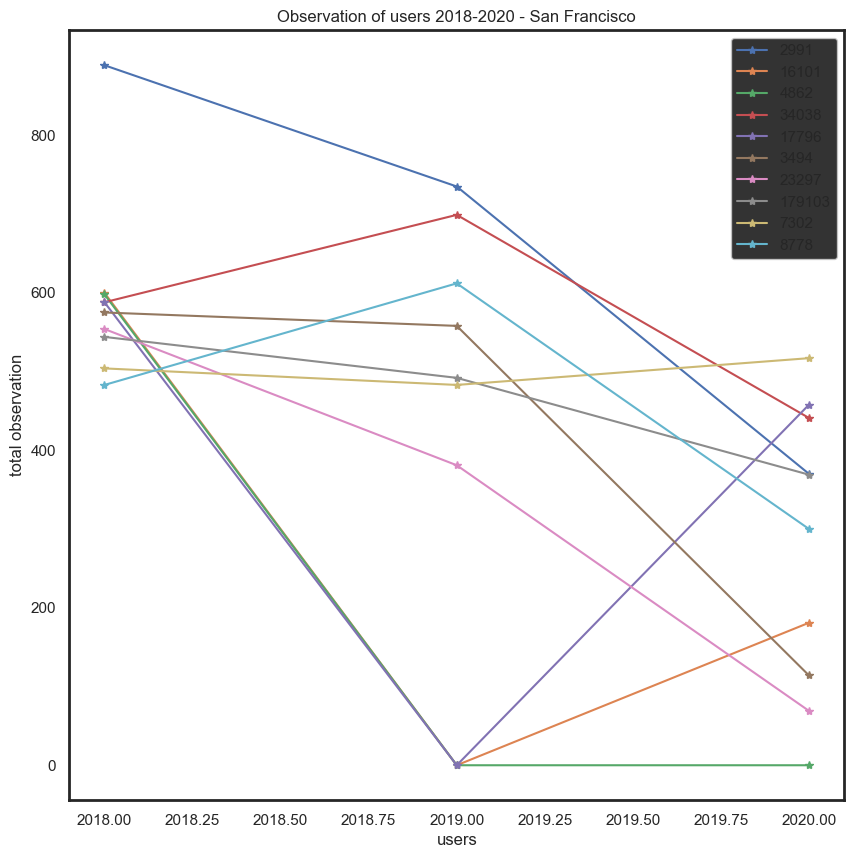

In [242]:
sf_ob = sf_ob.set_index('user_id')[:10]
fig, ax = plt.subplots(figsize=(10,10))
for index, row in sf_ob.iterrows():
    plt.plot(row, label=index,marker="*")
#plt.xscale('log')
#plt.yscale('log')

# Add a legend to the plot
plt.title('Observation of users 2018-2020 - San Francisco')
plt.xlabel('users')
plt.ylabel('total observation')
plt.legend()
plt.show()

Text(0.5, 1.0, 'San Fransisco - Observation ')

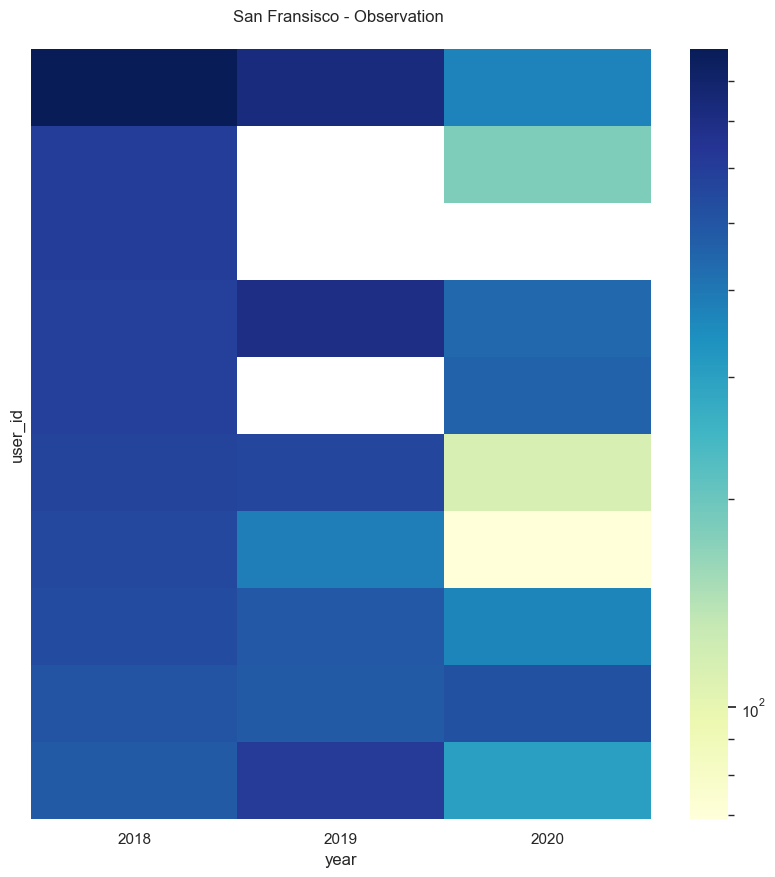

In [252]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(sf_ob[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('San Fransisco - Observation ',fontsize = 12, pad=20)

### Progress for three years - SF identification

In [253]:
sf_iden = sf_dbo.groupby(['user_id','year'])['n_idents'].agg("sum").unstack().fillna(0).astype(float)
sf_iden = sf_iden.sort_values([2018],ascending=False)
sf_iden

year,2018,2019,2020
user_id,,,
17695,5568.0,4997.0,0.0
179103,3226.0,2934.0,3494.0
425620,2187.0,2519.0,86.0
32763,2076.0,498.0,0.0
13377,1999.0,1622.0,0.0
...,...,...,...
798633,0.0,0.0,0.0
797418,0.0,12.0,0.0
797207,0.0,0.0,0.0


Text(0.5, 1.0, 'San Fransico Identification  ')

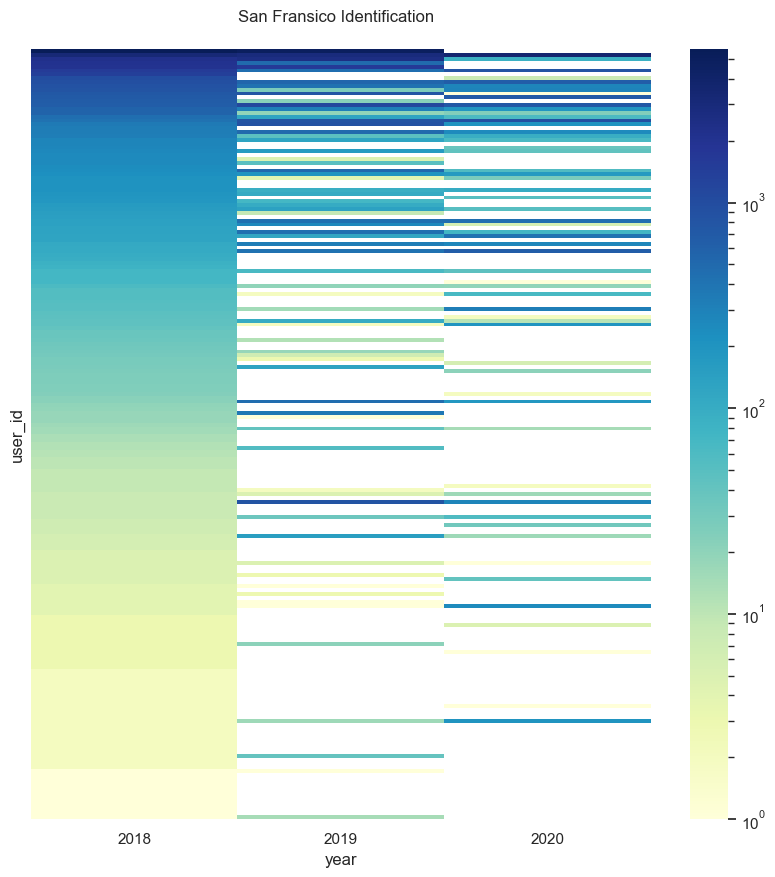

In [254]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(sf_iden[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('San Fransico Identification  ',fontsize = 12, pad=20)

## Cumulative - San Fransisco Observation and Identification for all three years

In [255]:
sf_cum = sf_dbo.groupby('user_id')[['n_obs', 'n_idents']].sum().sort_values([('n_obs')], ascending=False).astype(float)
sf_cum

,n_obs,n_idents
user_id,,
2991,1994.0,1153.0
34038,1728.0,1093.0
7302,1504.0,247.0
179103,1405.0,9654.0
46415,1398.0,385.0
...,...,...
911331,10.0,2.0
911282,10.0,0.0
907962,10.0,0.0


Text(0.5, 1.0, 'Cumulative Observation and Identification - San Fransisco  (2018-2020)')

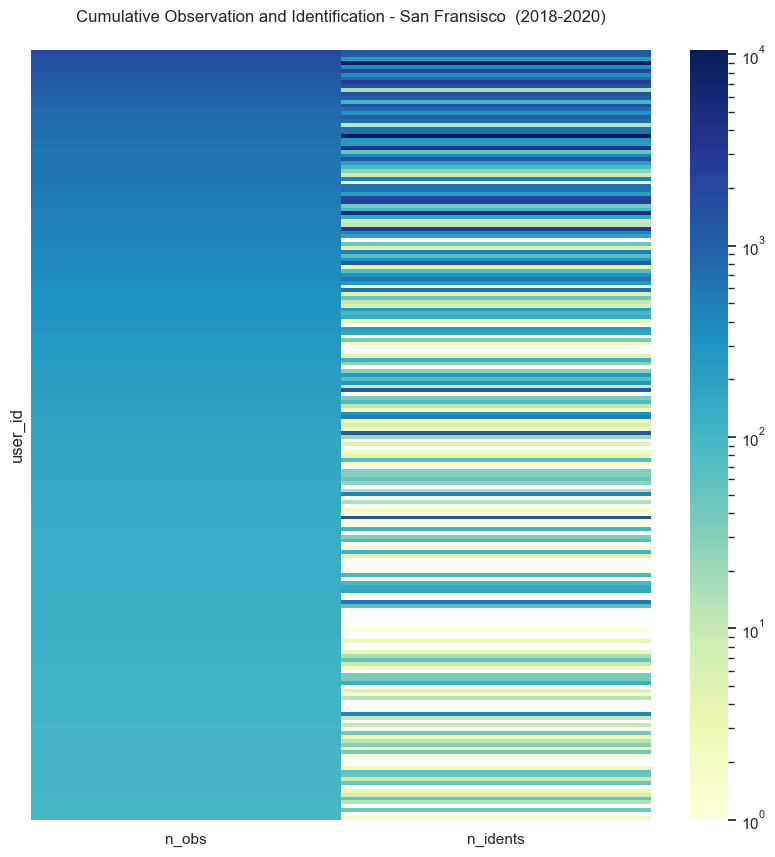

In [256]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(sf_cum[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm())
ax.set_title('Cumulative Observation and Identification - San Fransisco  (2018-2020)',fontsize = 12, pad=20)
            

# Los Angeles

In [257]:
la_dbo = dfobs[dfobs.city == 'Los_Angeles'].sort_values(['n_obs'], ascending = False)
la_dbo = la_dbo[la_dbo['n_obs'] >= 10]
la_dbo

,user_id,n_obs,n_idents,participation cumulative,participation difference,participation index,city,year
176,12809,1414,219,3.213252,3.077731,0.731782,Los_Angeles,2018
523,12809,1189,1541,3.436322,2.547775,0.128938,Los_Angeles,2019
516,34687,1059,27,3.03623,3.0141,0.950276,Los_Angeles,2019
187,34687,960,5,2.984977,2.980458,0.989637,Los_Angeles,2018
158,81779,825,613,3.158061,2.32838,0.147427,Los_Angeles,2019
...,...,...,...,...,...,...,...,...
383,1655175,10,0,1.041393,1.041393,1.0,Los_Angeles,2019
653,391160,10,1,1.079181,1.0,0.818182,Los_Angeles,2020
513,171166,10,33,1.643453,1.380211,0.534884,Los_Angeles,2019
483,2809793,10,0,1.041393,1.041393,1.0,Los_Angeles,2020


Text(0.5, 0.98, 'Cumulative User Observation by year - Los Angeles')

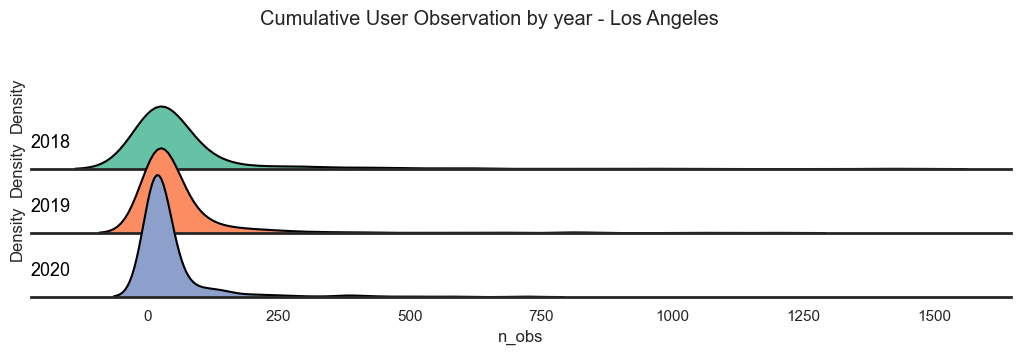

In [258]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(la_dbo, palette=palette, row="year", hue="year", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="n_obs", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="n_obs", color='black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "year")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="n_obs")
g.despine( left=True)

plt.suptitle('Cumulative User Observation by year - Los Angeles', y=0.98)

### progress for three years - LA Observation 

In [259]:
la_ob = la_dbo.groupby(['user_id','year'])['n_obs'].agg("sum").unstack().fillna(0).astype(float)
la_ob = la_ob.sort_values([2018],ascending=False)
la_ob

year,2018,2019,2020
user_id,,,
12809,1414.0,1189.0,0.0
34687,960.0,1059.0,444.0
223005,767.0,810.0,505.0
220795,616.0,512.0,321.0
21786,599.0,349.0,0.0
...,...,...,...
1212786,0.0,14.0,0.0
1214031,0.0,19.0,0.0
1239300,0.0,59.0,0.0


In [273]:
la_ob.columns=la_ob.columns
la_ob.reset_index(inplace=True)
la_ob

year,user_id,2018,2019,2020
0,12809,1414.0,1189.0,0.0
1,34687,960.0,1059.0,444.0
2,223005,767.0,810.0,505.0
3,220795,616.0,512.0,321.0
4,21786,599.0,349.0,0.0
5,81779,552.0,825.0,265.0
6,100933,463.0,158.0,0.0
7,74669,442.0,395.0,229.0
8,455833,437.0,0.0,0.0
9,1850,401.0,398.0,136.0


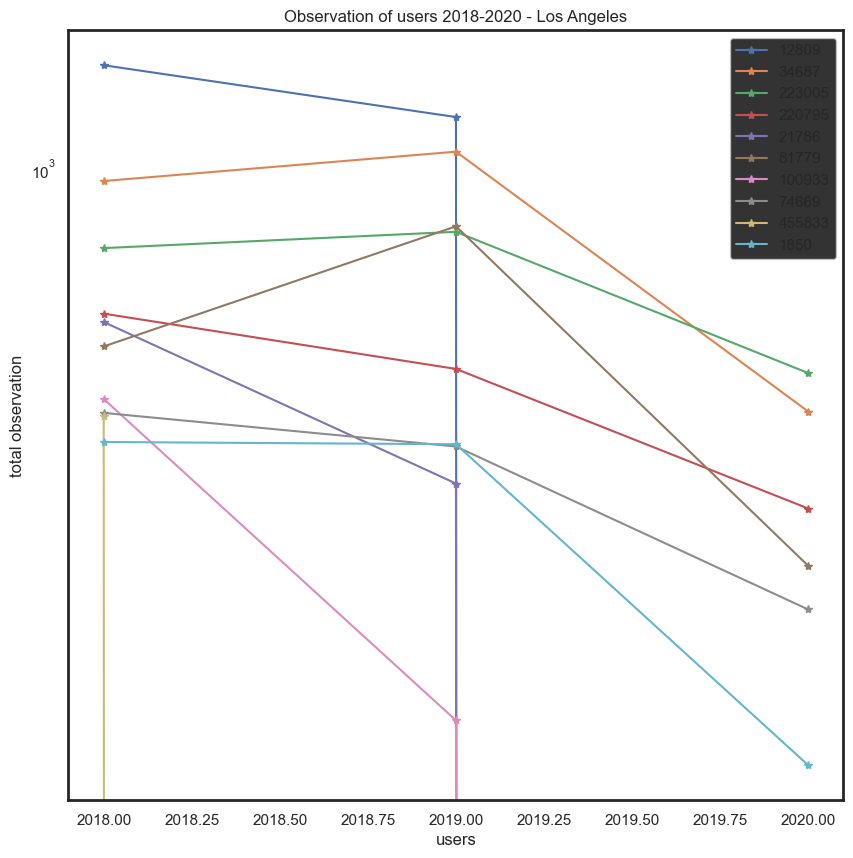

In [274]:
la_ob = la_ob.set_index('user_id')[:10]
fig, ax = plt.subplots(figsize=(10,10))
for index, row in la_ob.iterrows():
    plt.plot(row, label=index,marker="*")
#plt.xscale('log')
plt.yscale('log')

# Add a legend to the plot
plt.title('Observation of users 2018-2020 - Los Angeles')
plt.xlabel('users')
plt.ylabel('total observation')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Los Angeles  Observation - ')

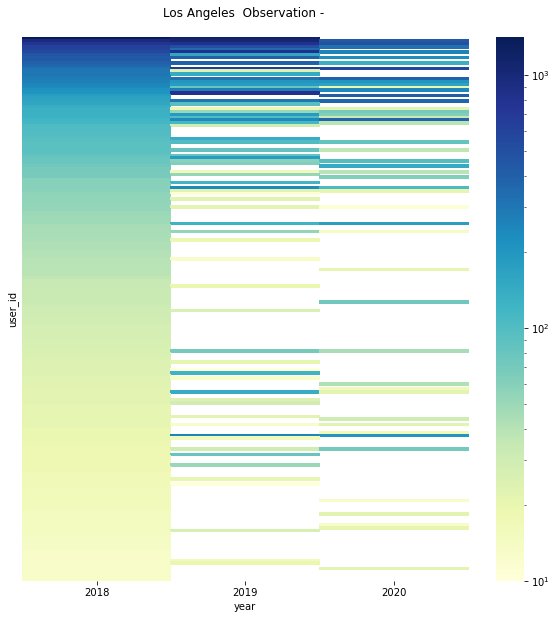

In [52]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(la_ob[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('Los Angeles  Observation - ',fontsize = 12, pad=20)

### progress for three years - LA Identification

In [53]:
la_iden = la_dbo.groupby(['user_id','year'])['n_idents'].agg("sum").unstack().fillna(0).astype(float)
la_iden = la_iden.sort_values([2018],ascending=False)
la_iden

year,2018,2019,2020
user_id,,,
52839,2179.0,1982.0,0.0
427782,1538.0,1377.0,1026.0
392423,632.0,0.0,0.0
80984,480.0,968.0,544.0
39264,373.0,0.0,10.0
...,...,...,...
900766,0.0,0.0,0.0
901870,0.0,0.0,0.0
901887,0.0,0.0,0.0


Text(0.5, 1.0, 'Los Angels  Identification  ')

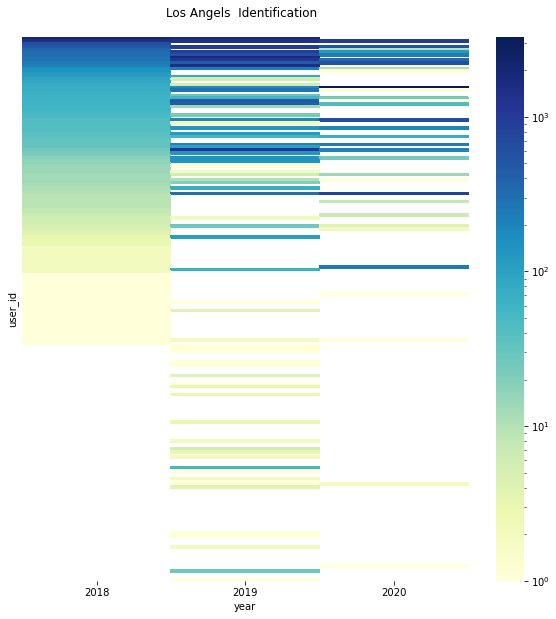

In [65]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(la_iden[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('Los Angels  Identification  ',fontsize = 12, pad=20)

## Cumulative - LA Observation and Identification 

In [55]:
la_cum = la_dbo.groupby('user_id')[['n_obs', 'n_idents']].sum().sort_values([('n_obs')], ascending=False).astype(float)
la_cum

,n_obs,n_idents
user_id,,
12809,2603.0,1760.0
34687,2463.0,36.0
223005,2082.0,25.0
81779,1642.0,1161.0
421748,1544.0,193.0
...,...,...
2832793,10.0,0.0
1573935,10.0,0.0
2829168,10.0,13.0


Text(0.5, 1.0, 'Cumulative Observation and Identification - Los Angels  (2018-2020)')

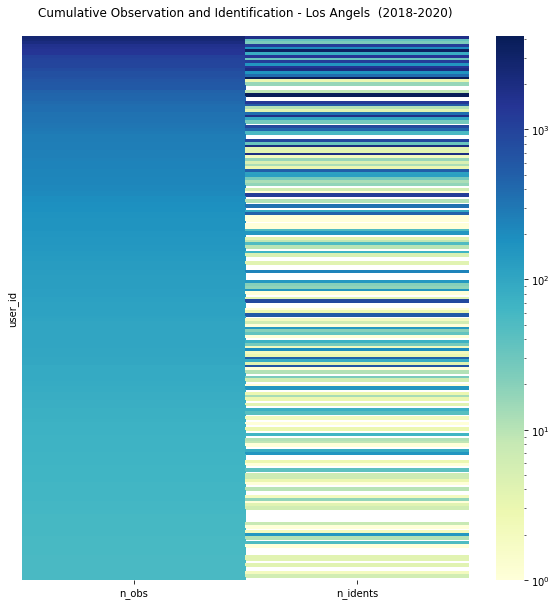

In [56]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(la_cum[:200], cmap="YlGnBu", fmt='g',ax=ax,yticklabels=False,norm=LogNorm());
ax.set_title('Cumulative Observation and Identification - Los Angels  (2018-2020)',fontsize = 12, pad=20)

### Participation Score - London

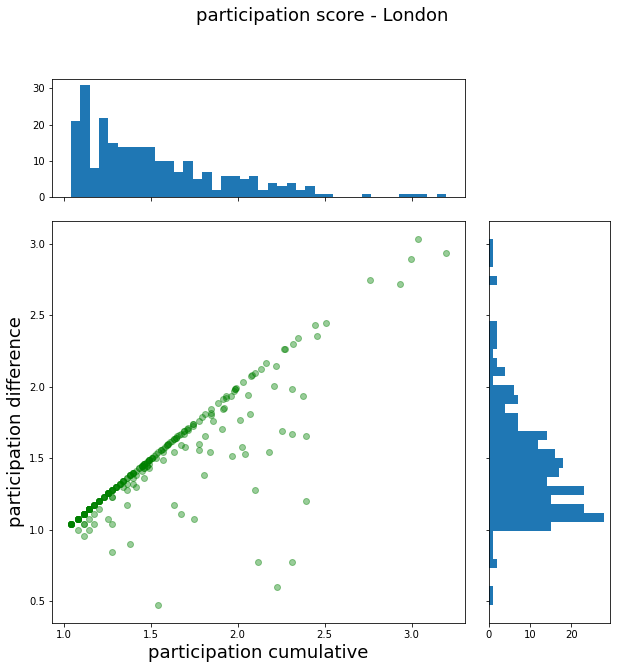

In [70]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

x = lon_dbo['participation cumulative']
y = lon_dbo['participation difference']

fig = plt.figure(figsize=(10,10))


gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:5,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:5,3])

ax_joint.scatter(x,y,color="green", alpha=0.4, norm=LogNorm())
ax_marg_x.hist(x, bins= 40)
ax_marg_y.hist(y,bins= 40, orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
fig.suptitle('participation score - London', fontsize=18)
ax_joint.set_xlabel('participation cumulative', fontsize=18)
ax_joint.set_ylabel('participation difference', fontsize=18)

# Set labels on marginals
#ax_marg_y.set_xlabel('participation dif')
#ax_marg_x.set_ylabel('participation cumilative')
plt.show()
fig.savefig('participation_score.jpg')

### Participation Score - San Fransisco

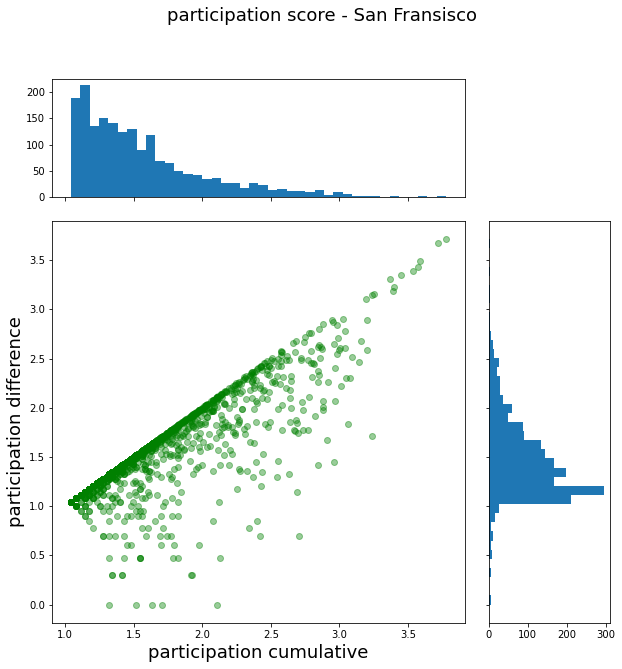

In [71]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

x = sf_dbo['participation cumulative']
y = sf_dbo['participation difference']

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:5,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:5,3])

ax_joint.scatter(x,y,color="green", alpha=0.4,norm=LogNorm() )
ax_marg_x.hist(x, bins= 40)
ax_marg_y.hist(y,bins= 40, orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
fig.suptitle('participation score - San Fransisco', fontsize=18)
ax_joint.set_xlabel('participation cumulative', fontsize=18)
ax_joint.set_ylabel('participation difference', fontsize=18)

# Set labels on marginals
#ax_marg_y.set_xlabel('participation dif')
#ax_marg_x.set_ylabel('participation cumilative')
plt.show()
fig.savefig('participation_score.jpg')

### Participation Score - Los Angeles

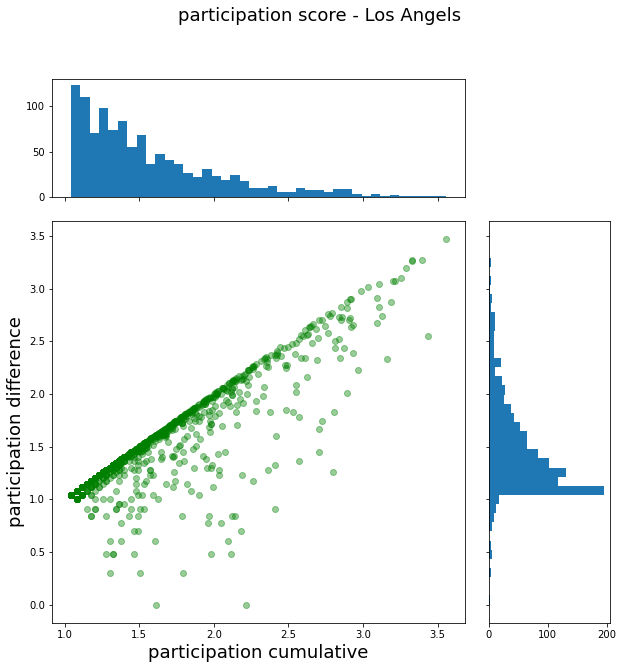

In [63]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

x = la_dbo['participation cumulative']
y = la_dbo['participation difference']

fig = plt.figure(figsize=(10,10))


gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:5,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:5,3])

ax_joint.scatter(x,y,color="green", alpha=0.4, )
ax_marg_x.hist(x, bins= 40)
ax_marg_y.hist(y,bins= 40, orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
fig.suptitle('participation score - Los Angels ', fontsize=18)
ax_joint.set_xlabel('participation cumulative', fontsize=18)
ax_joint.set_ylabel('participation difference', fontsize=18)

# Set labels on marginals
#ax_marg_y.set_xlabel('participation dif')
#ax_marg_x.set_ylabel('participation cumilative')
plt.show()
fig.savefig('participation_score.jpg')